## Resolución del Problema Inverso, estimar $a_{e0}$ y $v_1$
#### Modelo PK/PD del propofol



In [ ]:
#Importamos librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
#Defino la función a trozos
def u(t):
    if t <= 0.5467:
        return 106.0907
    else:
        return 0.0

In [ ]:
#Parámetros de las ecuaciones

#Condiciones inciales, todas ceros porque no se ha recibido anestesia
x1_0 = 0
x2_0 = 0
x3_0 = 0
x4_0 = 0
T_max = 3 #en minutos
yinit = [x1_0, x2_0, x3_0, x4_0]

#Parámetros para 53 años, 77kg y 177 cm
a10 = 0.4015
a12 = 0.320
a13 = 0.196
a21 = 0.0683
a31 = 0.0035
ae0 = 0.456
v1 = 4.27

#Generando la variable independiente t
t_span = (0, 3)  # Desde t=0 hasta t=1.8397 min
t_eval = np.linspace(0, 3, 300)  # Puntos donde evaluar la solución

In [ ]:
#Definiendo el sistemas de ecuaciones diferenciales
def ode_model(t,y):
  x1, x2, x3, x4 = y
  d1_dt = -(a10 + a12 + a13)*x1 + a21*x2 + a31*x3 + u(t)#concentración en sangre
  d2_dt = a12*x1 - a21*x2 #compartimento músculo
  d3_dt = a13*x1 - a31*x3 #compartimento grasa
  d4_dt = (ae0/v1)*x1 - ae0*x4 #sitio de efecto
  return [d1_dt, d2_dt, d3_dt, d4_dt]

In [ ]:
#Resolver el sistema
sol = solve_ivp(ode_model, t_span, yinit, t_eval=t_eval, method="LSODA")

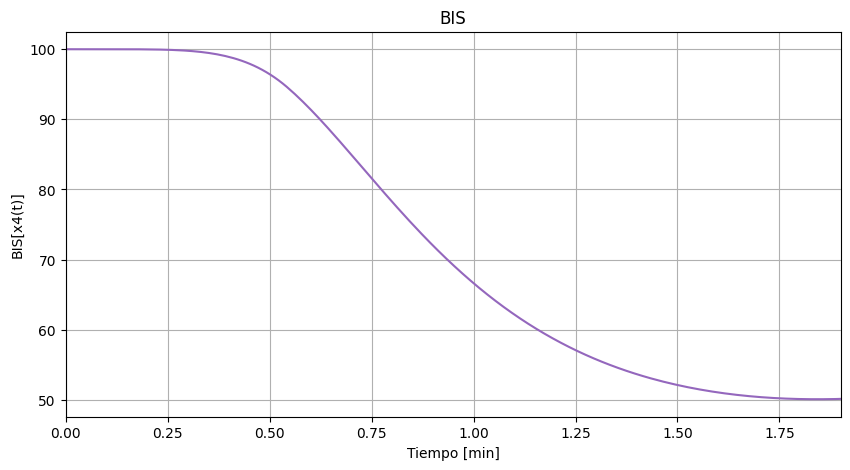

In [ ]:
# Parámetros BIS
BIS_0 = 100
gamma = 3
EC50 = 3.4

# Concentración en sitio de efecto
x4 = sol.y[3]

# Cálculo BIS según la fórmula dada
BIS = BIS_0 * (1 - (x4**gamma) / (EC50**gamma + x4**gamma))

# Graficar concentración y BIS
plt.figure(figsize=(10,5))
plt.plot(sol.t, BIS,color="C4")
plt.xlabel('Tiempo [min]')
plt.xlim(0, 1.9)
plt.ylabel('BIS[x4(t)]')
plt.title('BIS')
plt.grid(True)
plt.show()

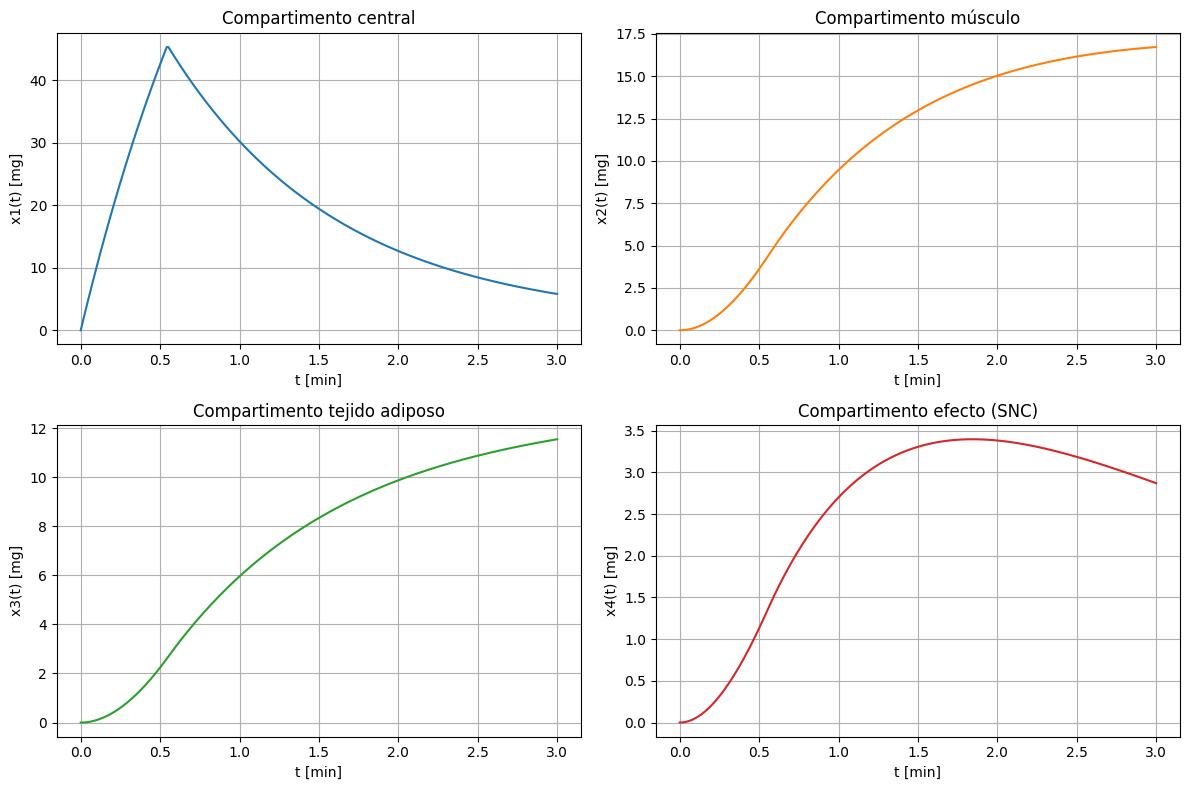

In [ ]:
# Graficar x1, x2, x3, x4 en estructura 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

labels = ['x1(t) [mg]', 'x2(t) [mg]', 'x3(t) [mg]', 'x4(t) [mg]']

for i in range(4):
    row, col = divmod(i, 2)
    axs[row, col].plot(sol.t, sol.y[i], color=f"C{i}")
    axs[row, col].set_ylabel(labels[i])
    axs[row, col].grid()

axs[0, 0].set_xlabel("t [min]")
axs[1, 0].set_xlabel("t [min]")
axs[0, 1].set_xlabel("t [min]")
axs[1, 1].set_xlabel("t [min]")
axs[0, 0].set_title("Compartimento central")
axs[1, 0].set_title("Compartimento tejido adiposo")
axs[0, 1].set_title("Compartimento músculo")
axs[1, 1].set_title("Compartimento efecto (SNC)")

plt.tight_layout()
plt.show()

In [ ]:
t_np = sol.t
x1_np, x2_np, x3_np, x4_np = sol.y

#Convertimos a tensores
t_all = torch.tensor(t_np, dtype=torch.float32).view(-1, 1)
x1_all = torch.tensor(x1_np, dtype=torch.float32).view(-1, 1)
x2_all = torch.tensor(x2_np, dtype=torch.float32).view(-1, 1)
x3_all = torch.tensor(x3_np, dtype=torch.float32).view(-1, 1)
x4_all = torch.tensor(x4_np, dtype=torch.float32).view(-1, 1)

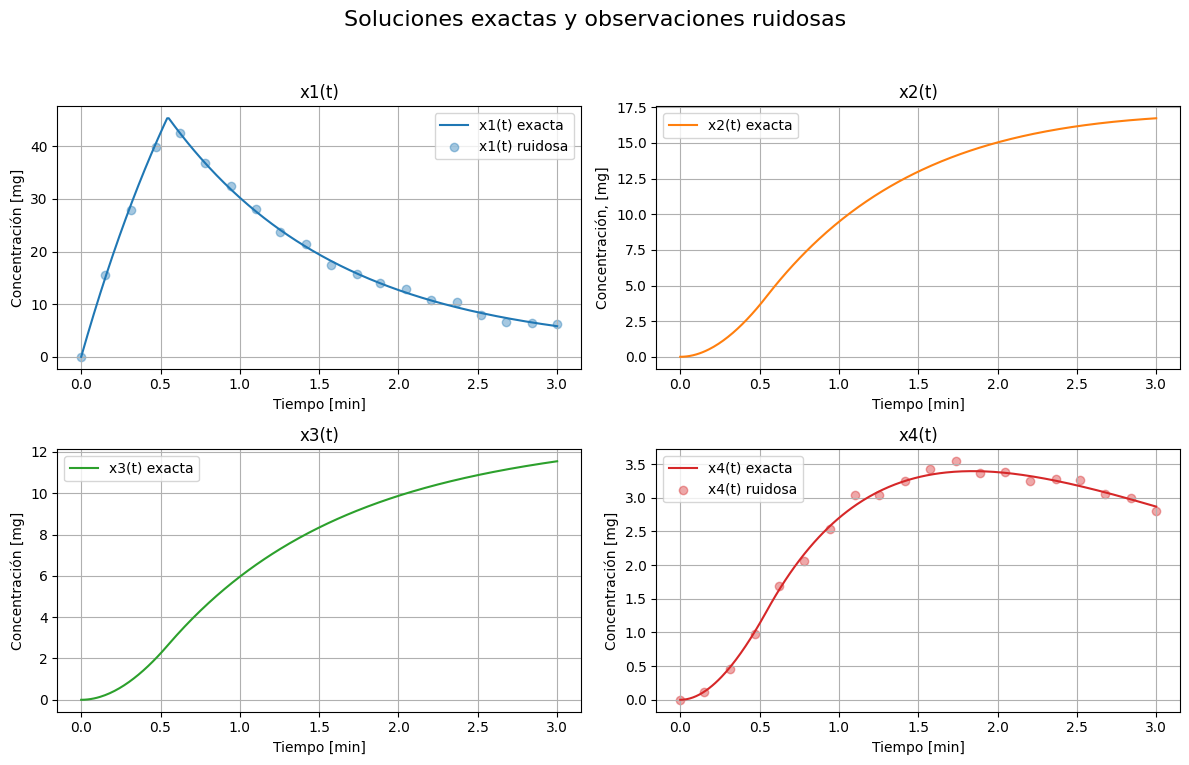

In [ ]:
# Datos observacionales ruidosos
torch.manual_seed(2)

# Número de muestras equiespaciadas
n_obs = 20

# Índices equiespaciados desde 0 hasta el último índice
idx_obs = torch.linspace(0, t_all.shape[0] - 1, steps=n_obs).long()

# Tiempos observacionales equiespaciados
t_obs = t_all[idx_obs]

# Extraemos los valores exactos de A, B y E en esos tiempos
x1_obs = x1_all[idx_obs]
#x2_obs = x2_all[idx_obs]
#x3_obs = x3_all[idx_obs]
x4_obs = x4_all[idx_obs]

# Añadimos ruido gaussiano (media 0, desviación 0.04)
x1_obs_r = torch.clamp(x1_obs + 0.6 * torch.randn_like(x1_obs), min=0.0)
#x2_obs_r = x2_obs + 0.2 * torch.randn_like(x2_obs)
#x3_obs_r = x3_obs + 0.2 * torch.randn_like(x3_obs)
x4_obs_r = torch.clamp(x4_obs + 0.06 * torch.randn_like(x4_obs), min=0.0)

#visualización
# Visualización en cuadrícula 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Soluciones exactas y observaciones ruidosas", fontsize=16)

# x1
axs[0, 0].plot(t_all, x1_all, label="x1(t) exacta", color="tab:blue")
axs[0, 0].scatter(t_obs, x1_obs_r, label="x1(t) ruidosa", color="tab:blue", alpha=0.4)
axs[0, 0].set_title("x1(t)")
axs[0, 0].set_xlabel("Tiempo [min]")
axs[0, 0].set_ylabel("Concentración [mg]")
axs[0, 0].legend()
axs[0, 0].grid(True)

# x2
axs[0, 1].plot(t_all, x2_all, label="x2(t) exacta", color="tab:orange")
#axs[0, 1].scatter(t_obs, x2_obs_r, label="x2(t) ruidosa", color="tab:orange", alpha=0.4)
axs[0, 1].set_title("x2(t)")
axs[0, 1].set_xlabel("Tiempo [min]")
axs[0, 1].set_ylabel("Concentración, [mg]")
axs[0, 1].legend()
axs[0, 1].grid(True)

# x3
axs[1, 0].plot(t_all, x3_all, label="x3(t) exacta", color="tab:green")
#axs[1, 0].scatter(t_obs, x3_obs_r, label="x3(t) ruidosa", color="tab:green", alpha=0.4)
axs[1, 0].set_title("x3(t)")
axs[1, 0].set_xlabel("Tiempo [min]")
axs[1, 0].set_ylabel("Concentración [mg]")
axs[1, 0].legend()
axs[1, 0].grid(True)

# x4
axs[1, 1].plot(t_all, x4_all, label="x4(t) exacta", color="tab:red")
axs[1, 1].scatter(t_obs, x4_obs_r, label="x4(t) ruidosa", color="tab:red", alpha=0.4)
axs[1, 1].set_title("x4(t)")
axs[1, 1].set_xlabel("Tiempo [min]")
axs[1, 1].set_ylabel("Concentración [mg]")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

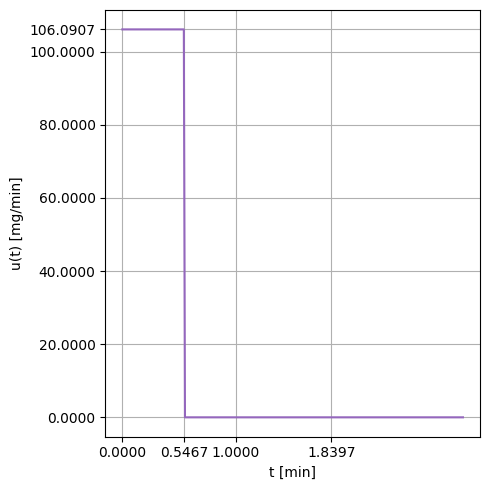

In [ ]:
# Evaluar y graficar u(t)
u_values = [u(t) for t in t_eval]

plt.figure(figsize=(5, 5))
plt.plot(t_eval, u_values, color="C4")

xticks = [0, 0.5467, 1, 1.8397]
plt.xticks(xticks, [f"{tick:.4f}" for tick in xticks])
yticks = [0, 20, 40, 60, 80, 100, 106.0907]
plt.yticks(yticks, [f"{tick:.4f}" for tick in yticks])
plt.ylabel("u(t) [mg/min]")
plt.xlabel("t [min]")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Red neuronal con ansatz
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, layers):
        super().__init__()
        activation = nn.Tanh
        self.input_layer = nn.Sequential(nn.Linear(in_dim, hidden_dim), activation())
        self.hidden_layers = nn.Sequential(*[
            nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation()) for _ in range(layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        t = x  # Claridad: x representa el tiempo
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return t * x

Paso 0: Pérdida total = 694.942078 | Física = 2054.544434 | Observaciones = 489.487640 | ae0 = 0.999000 | v1 = 1.999000


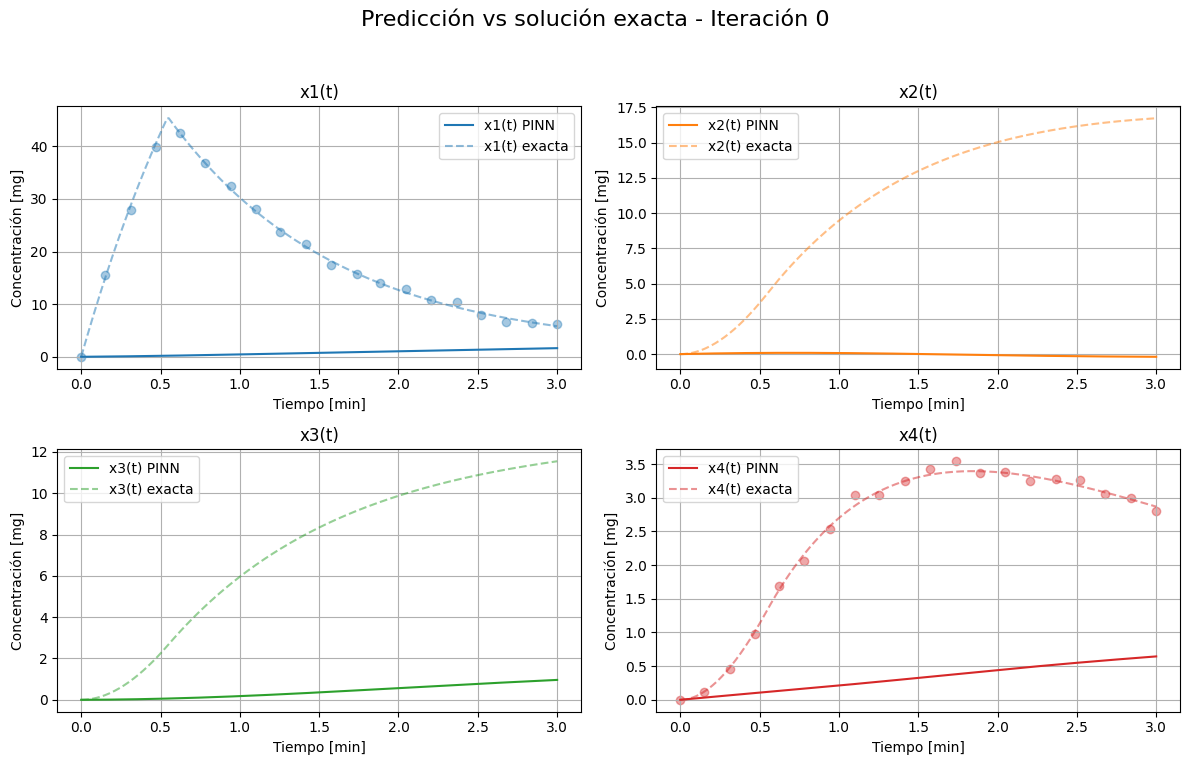

Paso 1000: Pérdida total = 82.482162 | Física = 472.845123 | Observaciones = 35.197651 | ae0 = 0.299743 | v1 = 2.509033
Paso 2000: Pérdida total = 8.819613 | Física = 58.671780 | Observaciones = 2.952434 | ae0 = 0.241905 | v1 = 2.610616
Paso 3000: Pérdida total = 2.785470 | Física = 21.597269 | Observaciones = 0.625743 | ae0 = 0.247486 | v1 = 2.733456
Paso 4000: Pérdida total = 1.212286 | Física = 8.385382 | Observaciones = 0.373747 | ae0 = 0.282804 | v1 = 2.951552
Paso 5000: Pérdida total = 0.543209 | Física = 2.861061 | Observaciones = 0.257103 | ae0 = 0.324633 | v1 = 3.276325


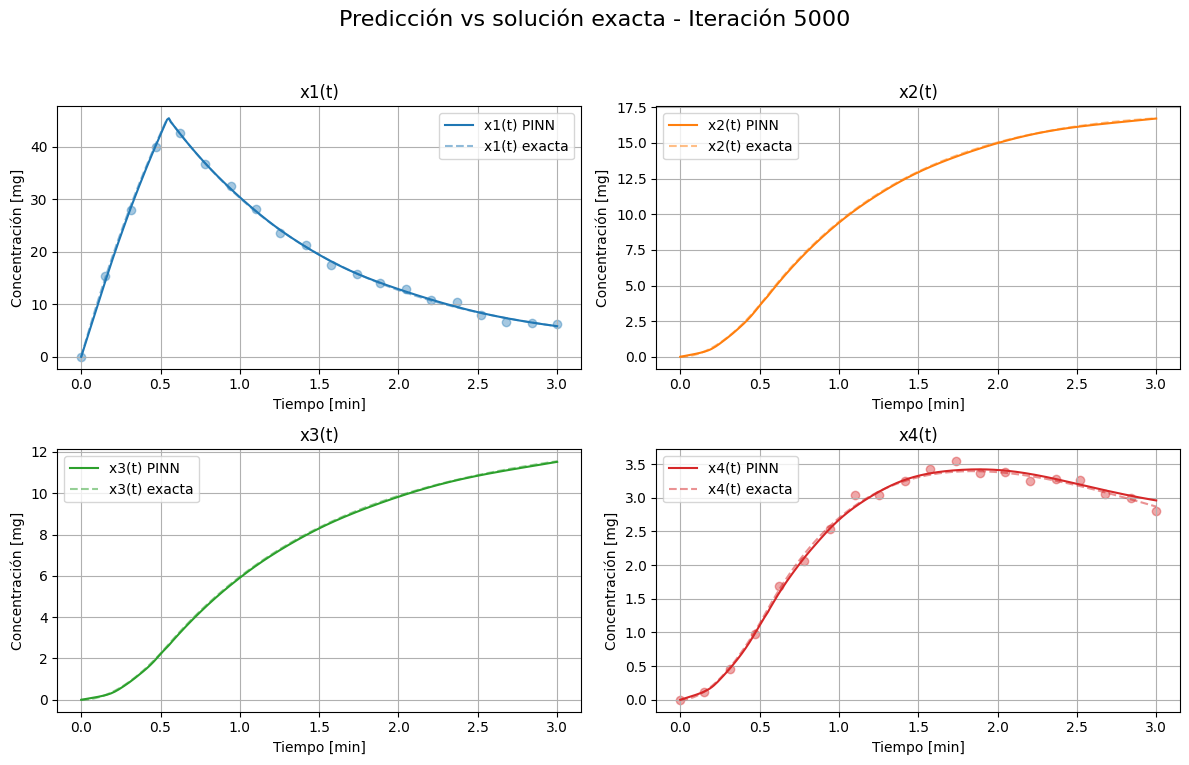

Paso 6000: Pérdida total = 0.357105 | Física = 1.309780 | Observaciones = 0.226127 | ae0 = 0.376131 | v1 = 3.659617
Paso 7000: Pérdida total = 0.282111 | Física = 0.653399 | Observaciones = 0.216771 | ae0 = 0.423606 | v1 = 4.006903
Paso 8000: Pérdida total = 0.280237 | Física = 0.584619 | Observaciones = 0.221775 | ae0 = 0.453283 | v1 = 4.220204
Paso 9000: Pérdida total = 0.250875 | Física = 0.376636 | Observaciones = 0.213212 | ae0 = 0.462617 | v1 = 4.288482
Paso 10000: Pérdida total = 0.245145 | Física = 0.337268 | Observaciones = 0.211418 | ae0 = 0.463841 | v1 = 4.297183


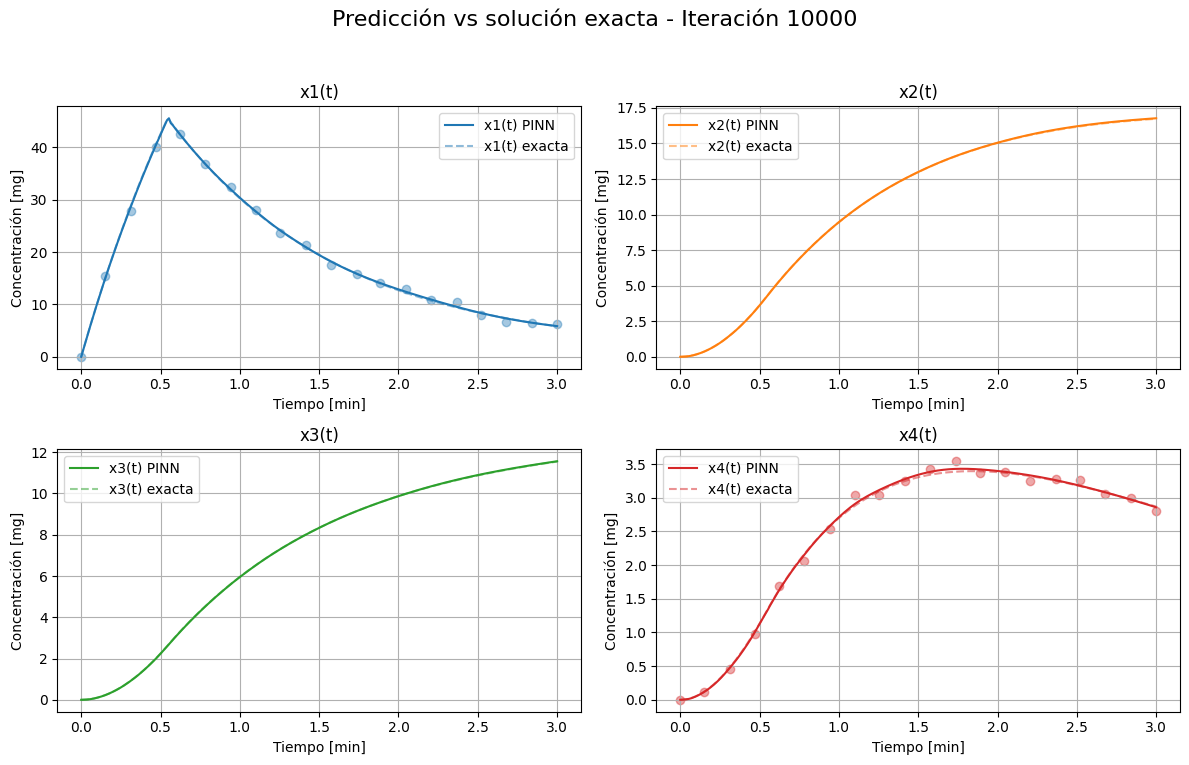

Paso 11000: Pérdida total = 0.243701 | Física = 0.327533 | Observaciones = 0.210948 | ae0 = 0.464678 | v1 = 4.302037
Paso 12000: Pérdida total = 0.241786 | Física = 0.332045 | Observaciones = 0.208581 | ae0 = 0.465538 | v1 = 4.306895
Paso 13000: Pérdida total = 0.241090 | Física = 0.329496 | Observaciones = 0.208140 | ae0 = 0.465941 | v1 = 4.309312
Paso 14000: Pérdida total = 0.240508 | Física = 0.324324 | Observaciones = 0.208075 | ae0 = 0.466047 | v1 = 4.309820
Paso 15000: Pérdida total = 0.239775 | Física = 0.322441 | Observaciones = 0.207531 | ae0 = 0.466029 | v1 = 4.309913


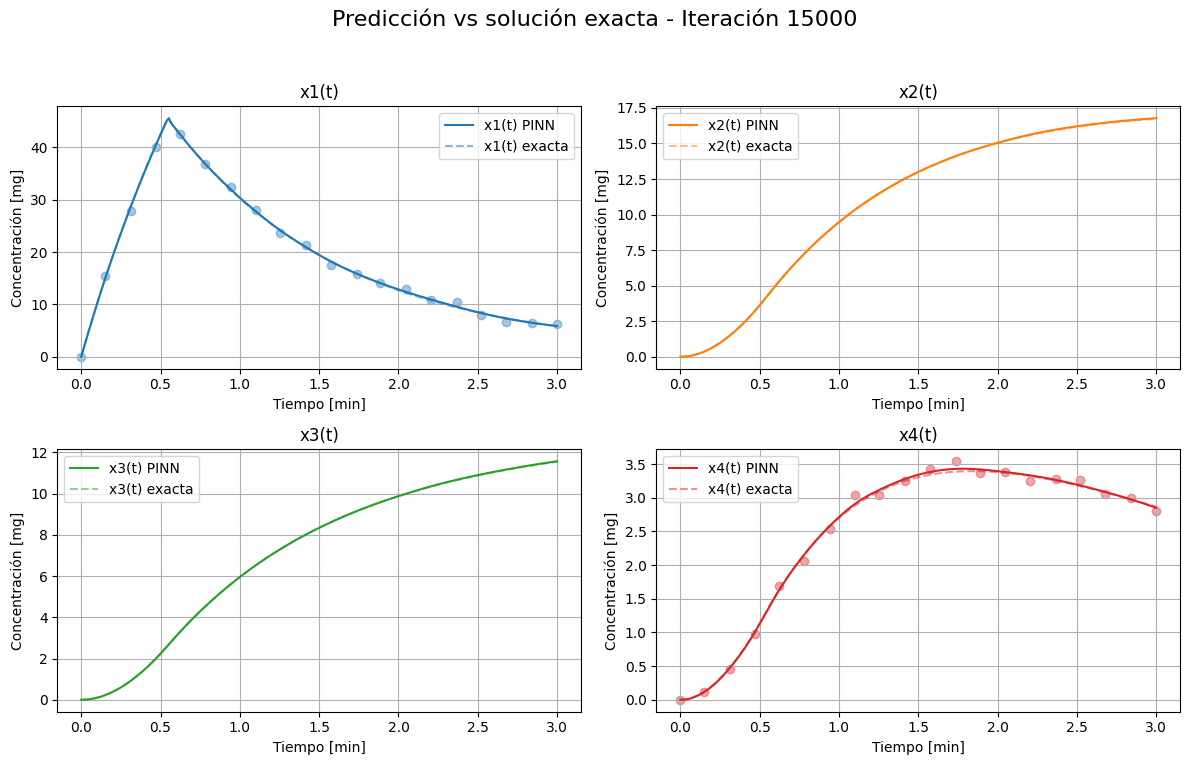

Paso 16000: Pérdida total = 0.239075 | Física = 0.318155 | Observaciones = 0.207260 | ae0 = 0.466052 | v1 = 4.310089
Paso 17000: Pérdida total = 0.238398 | Física = 0.313583 | Observaciones = 0.207039 | ae0 = 0.465895 | v1 = 4.309169
Paso 18000: Pérdida total = 0.237709 | Física = 0.319101 | Observaciones = 0.205799 | ae0 = 0.465875 | v1 = 4.308531
Paso 19000: Pérdida total = 0.236406 | Física = 0.312271 | Observaciones = 0.205179 | ae0 = 0.465742 | v1 = 4.308560
Paso 20000: Pérdida total = 0.235286 | Física = 0.310087 | Observaciones = 0.204277 | ae0 = 0.465722 | v1 = 4.308560


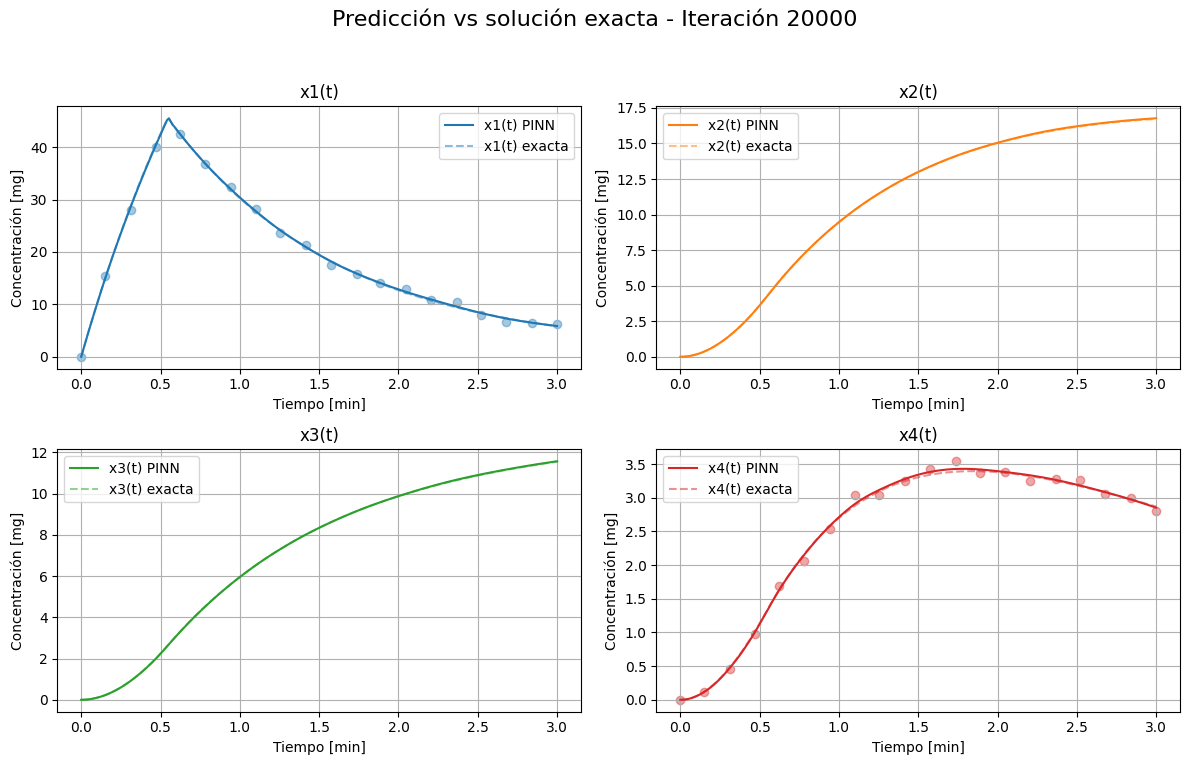

Paso 21000: Pérdida total = 0.234129 | Física = 0.308639 | Observaciones = 0.203265 | ae0 = 0.465728 | v1 = 4.308764
Paso 22000: Pérdida total = 0.233232 | Física = 0.304183 | Observaciones = 0.202813 | ae0 = 0.465759 | v1 = 4.308859
Paso 23000: Pérdida total = 0.231934 | Física = 0.304457 | Observaciones = 0.201488 | ae0 = 0.465783 | v1 = 4.309497
Paso 24000: Pérdida total = 0.231018 | Física = 0.305126 | Observaciones = 0.200505 | ae0 = 0.465841 | v1 = 4.310045
Paso 25000: Pérdida total = 0.230778 | Física = 0.310005 | Observaciones = 0.199777 | ae0 = 0.465921 | v1 = 4.310309


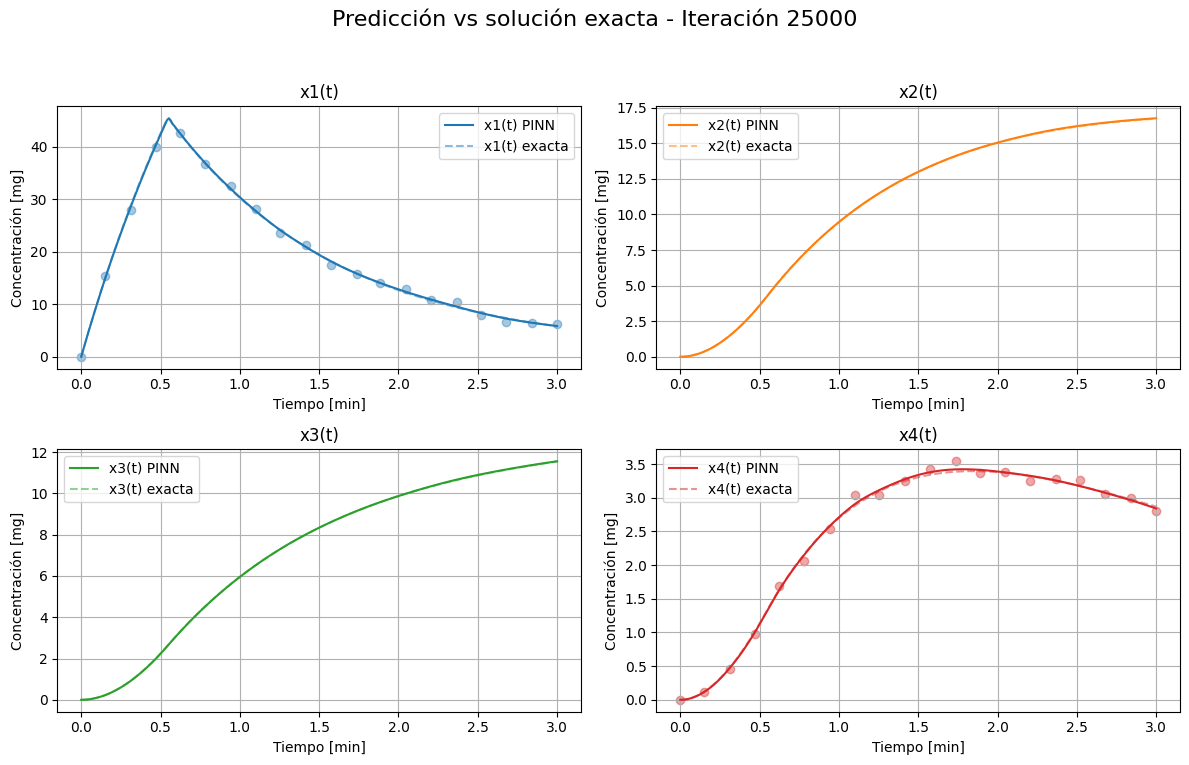

In [ ]:
# Inicialización
torch.manual_seed(2)
pinn = FCN(1, 4, 64, 2)

ae0 = torch.nn.Parameter(torch.ones(1), requires_grad=True)
v1 = torch.nn.Parameter(torch.tensor([2.0]), requires_grad=True)

optimizer = torch.optim.Adam(list(pinn.parameters()) + [ae0, v1], lr=1e-3)

lambda_phys = 1e-1
lambda_obs = 1

# Tiempo real [min]
t_boundary = torch.tensor([[0.0]], requires_grad=True)
t_physics = torch.linspace(0, T_max, 256).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, T_max, 256).view(-1, 1)
t_obs = t_obs.requires_grad_(True)

# Almacenamiento de pérdidas
loss_total_list = []
loss_phys_list = []
loss_obs_list = []
ae0s = []
v1s = []

x1_sol, x2_sol, x3_sol, x4_sol = sol.y

# Redefinimos u(t) para trabajar en escala real
def u(t):
    return torch.where(t <= 0.5467, torch.tensor(106.0907, dtype=t.dtype, device=t.device), torch.tensor(0.0, dtype=t.dtype, device=t.device))

for i in range(25001):
    optimizer.zero_grad()

    # Condiciones físicas
    pred_phys = pinn(t_physics)
    x1, x2, x3, x4 = pred_phys[:, 0:1], pred_phys[:, 1:2], pred_phys[:, 2:3], pred_phys[:, 3:4]

    # Derivadas respecto a tiempo real
    d1_dt = torch.autograd.grad(x1, t_physics, torch.ones_like(x1), create_graph=True)[0]
    d2_dt = torch.autograd.grad(x2, t_physics, torch.ones_like(x2), create_graph=True)[0]
    d3_dt = torch.autograd.grad(x3, t_physics, torch.ones_like(x3), create_graph=True)[0]
    d4_dt = torch.autograd.grad(x4, t_physics, torch.ones_like(x4), create_graph=True)[0]

    # Observaciones
    pred_obs = pinn(t_obs)
    x1_pred_obs = pred_obs[:, 0:1]
    #x2_pred_obs = pred_obs[:, 1:2]
    #x3_pred_obs = pred_obs[:, 2:3]
    x4_pred_obs = pred_obs[:, 3:4]

    # Pérdidas físicas
    ode1 = d1_dt + (a10 + a12 + a13)*x1 - a21*x2 - a31*x3 - u(t_physics)
    ode2 = d2_dt - a12*x1 + a21*x2
    ode3 = d3_dt - a13*x1 + a31*x3
    ode4 = d4_dt - (ae0/v1)*x1 + ae0*x4
    loss_phys = (ode1**2).mean() + (ode2**2).mean() + (ode3**2).mean() + (ode4**2).mean()

    # Pérdidas observaciones
    loss_obs = torch.mean((x1_pred_obs - x1_obs_r)**2)  + torch.mean((x4_pred_obs - x4_obs_r)**2)

    # Pérdida total
    loss = lambda_phys * loss_phys + lambda_obs * loss_obs
    loss.backward()
    optimizer.step()

    # Añadir pérdidas a las listas
    loss_total_list.append(loss.item())
    loss_phys_list.append(loss_phys.item())
    loss_obs_list.append(loss_obs.item())
    ae0s.append(ae0.item())
    v1s.append(v1.item())

    # Mostrar info
    if i % 1000 == 0:
        print(f"Paso {i}: Pérdida total = {loss.item():.6f} | Física = {loss_phys.item():.6f} | Observaciones = {loss_obs.item():.6f} | ae0 = {ae0.item():.6f} | v1 = {v1.item():.6f}")

    if i % 5000 == 0:
        with torch.no_grad():
            pred = pinn(t_test)
            x1_pred = pred[:, 0].numpy()
            x2_pred = pred[:, 1].numpy()
            x3_pred = pred[:, 2].numpy()
            x4_pred = pred[:, 3].numpy()

            t_real = t_test.squeeze().numpy()

            # Gráfica (igual que antes, pero sin normalizar el eje x)
            fig, axs = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'Predicción vs solución exacta - Iteración {i}', fontsize=16)

            axs[0, 0].plot(t_real, x1_pred, label='x1(t) PINN', color='tab:blue')
            axs[0, 0].plot(t_eval, x1_sol, '--', label='x1(t) exacta', color='tab:blue', alpha=0.5)
            axs[0, 0].scatter(t_obs.numpy(), x1_obs_r.numpy(), color='tab:blue', alpha=0.4)
            axs[0, 0].set_title('x1(t)')
            axs[0, 0].set_xlabel('Tiempo [min]')
            axs[0, 0].set_ylabel('Concentración [mg]')
            axs[0, 0].legend()
            axs[0, 0].grid(True)

            axs[0, 1].plot(t_real, x2_pred, label='x2(t) PINN', color='tab:orange')
            axs[0, 1].plot(t_eval, x2_sol, '--', label='x2(t) exacta', color='tab:orange', alpha=0.5)
            #axs[0, 1].scatter(t_obs.numpy(), x2_obs_r.numpy(), color='tab:orange', alpha=0.4)
            axs[0, 1].set_title('x2(t)')
            axs[0, 1].set_xlabel('Tiempo [min]')
            axs[0, 1].set_ylabel('Concentración [mg]')
            axs[0, 1].legend()
            axs[0, 1].grid(True)

            axs[1, 0].plot(t_real, x3_pred, label='x3(t) PINN', color='tab:green')
            axs[1, 0].plot(t_eval, x3_sol, '--', label='x3(t) exacta', color='tab:green', alpha=0.5)
            #axs[1, 0].scatter(t_obs.numpy(), x3_obs_r.numpy(), color='tab:green', alpha=0.4)
            axs[1, 0].set_title('x3(t)')
            axs[1, 0].set_xlabel('Tiempo [min]')
            axs[1, 0].set_ylabel('Concentración [mg]')
            axs[1, 0].legend()
            axs[1, 0].grid(True)

            axs[1, 1].plot(t_real, x4_pred, label='x4(t) PINN', color='tab:red')
            axs[1, 1].plot(t_eval, x4_sol, '--', label='x4(t) exacta', color='tab:red', alpha=0.5)
            axs[1, 1].scatter(t_obs.numpy(), x4_obs_r.numpy(), color='tab:red', alpha=0.4)
            axs[1, 1].set_title('x4(t)')
            axs[1, 1].set_xlabel('Tiempo [min]')
            axs[1, 1].set_ylabel('Concentración [mg]')
            axs[1, 1].legend()
            axs[1, 1].grid(True)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

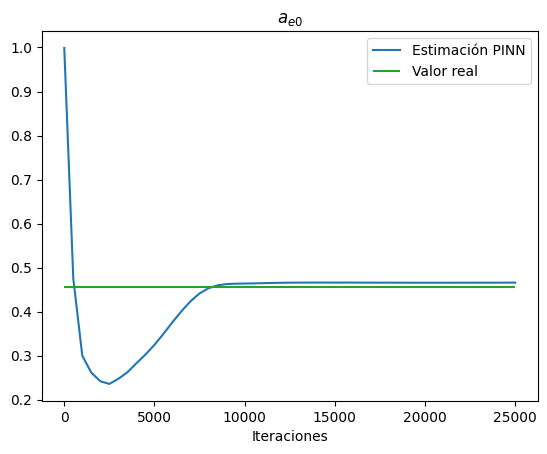

In [ ]:
pasos = np.arange(len(ae0s))
pasos_filtrados = pasos[::500]
ae0s_filtrados = ae0s[::500]

plt.figure()
plt.title(r"$a_{e0}$")
plt.plot(pasos_filtrados, ae0s_filtrados, label="Estimación PINN")
plt.hlines(0.456, pasos_filtrados[0], pasos_filtrados[-1], label="Valor real", color="tab:green")
plt.legend()
#plt.ylim(-0.01, 0.03)
plt.xlabel("Iteraciones")
plt.show()

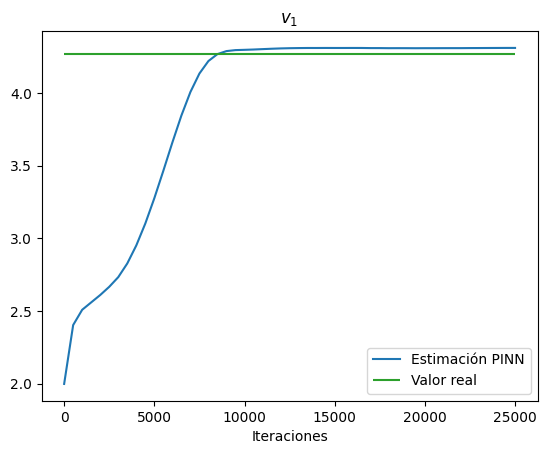

In [ ]:
pasos = np.arange(len(v1s))
pasos_filtrados = pasos[::500]
v1s_filtrados = v1s[::500]

plt.figure()
plt.title(r"$v_1$")
plt.plot(pasos_filtrados, v1s_filtrados, label="Estimación PINN")
plt.hlines(4.27, pasos_filtrados[0], pasos_filtrados[-1], label="Valor real", color="tab:green")
plt.legend()
#plt.ylim(-0.01, 0.03)
plt.xlabel("Iteraciones")
plt.show()

Cálculo ae0/v1

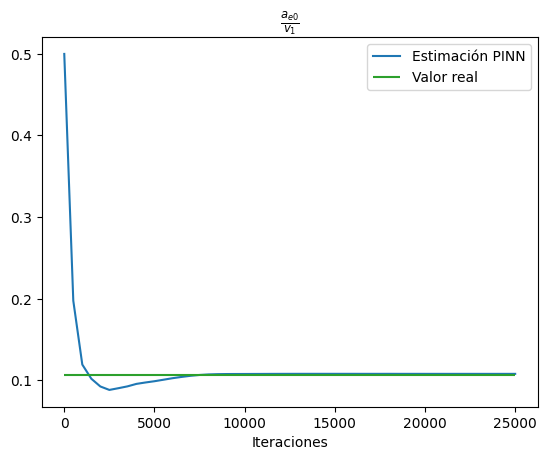

In [ ]:
plt.figure()
plt.title(r"$\frac{a_{e0}}{v_1}$")
plt.plot(pasos_filtrados, np.array(ae0s_filtrados) / np.array(v1s_filtrados), label="Estimación PINN")
plt.hlines(0.1068, pasos_filtrados[0], pasos_filtrados[-1], label="Valor real", color="tab:green")
plt.legend()
plt.xlabel("Iteraciones")
plt.show()


In [ ]:
print (ae0s[-1]/v1s[-1])

0.10809446490370515


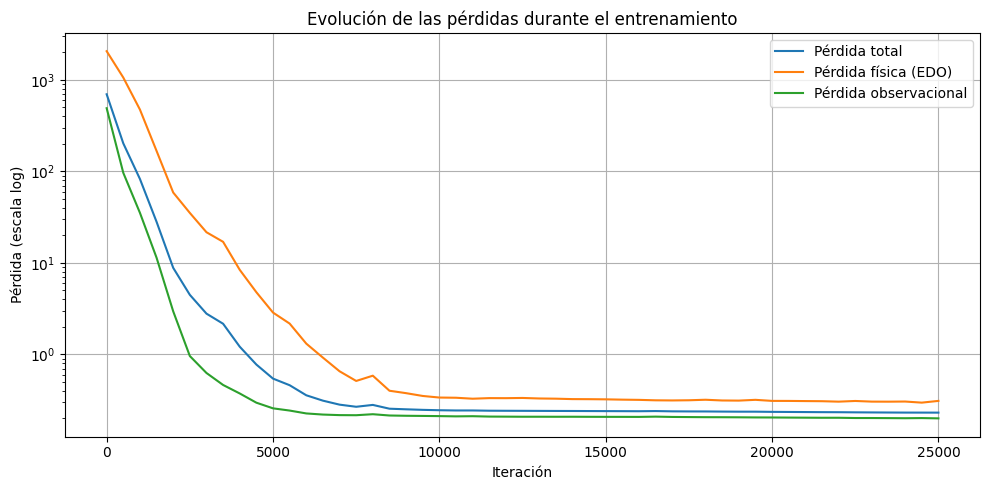

In [30]:
# Índices de iteración cada 1000 pasos
iters = list(range(0, len(loss_total_list),500))

# Submuestreo de las listas
loss_total_sub = loss_total_list[::500]
loss_phys_sub = loss_phys_list[::500]
loss_obs_sub = loss_obs_list[::500]

# Gráfica de pérdidas
plt.figure(figsize=(10, 5))
plt.plot(iters, loss_total_sub, label='Pérdida total')
plt.plot(iters,loss_phys_sub, label='Pérdida física (EDO)')
plt.plot(iters,loss_obs_sub, label='Pérdida observacional')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida (escala log)')
plt.title('Evolución de las pérdidas durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cálculo del BIS

In [ ]:
#Parámetros
bis0 = 100
gamma = 3
ec50 = 3.4

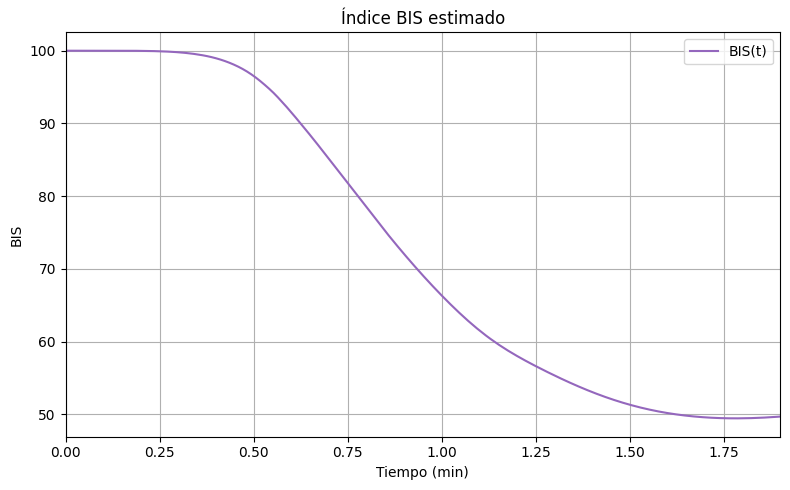

In [ ]:
x4_tensor = torch.tensor(x4_pred, dtype=torch.float32)

# Calculamos BIS(t)
BIS_pred = bis0 * (1 - (x4_tensor ** gamma) / ((x4_tensor ** gamma) + (ec50 ** gamma)))
BIS_pred = BIS_pred.numpy()  # para graficar más fácilmente

plt.figure(figsize=(8, 5))
plt.plot(t_real, BIS_pred, label='BIS(t)', color='tab:purple')
plt.title('Índice BIS estimado')
plt.xlabel('Tiempo (min)')
plt.ylabel('BIS')
plt.xlim(0,1.9)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## x1 vs x4

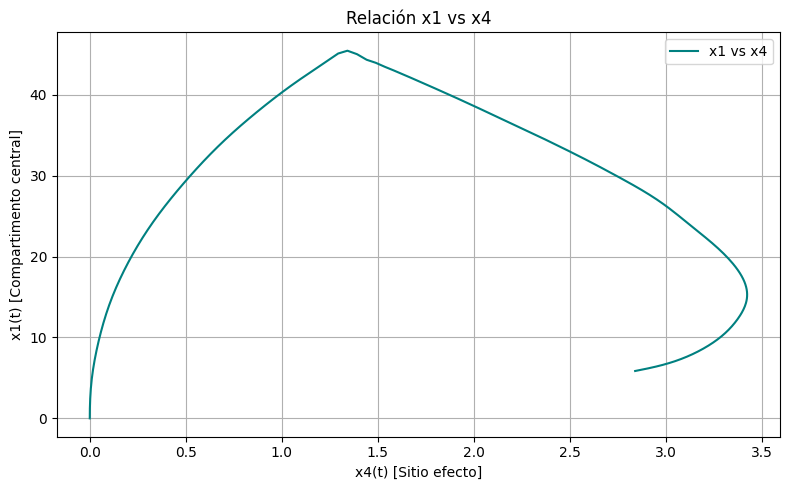

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x4_pred, x1_pred, color='teal', label='x1 vs x4')
plt.xlabel('x4(t) [Sitio efecto]')
plt.ylabel('x1(t) [Compartimento central]')
plt.title('Relación x1 vs x4')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## x4 vs x1 vs t

In [ ]:
import plotly.graph_objs as go

fig = go.Figure(data=[go.Scatter3d(
    x=x4_pred,
    y=x1_pred,
    z=t_real,
    mode='lines',
    line=dict(color='teal', width=4),
    name='Trayectoria'
)])

fig.update_layout(
    scene=dict(
        xaxis_title='x4(t) [compartimento efecto]',
        yaxis_title='x1(t) [compartimento central]',
        zaxis_title='Tiempo [min]',
    ),
    title='Evolución 3D de x1 vs x4 vs tiempo'
)

fig.show()
